In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import pickle

import tabula
import edgar

In [2]:
#Running a search for Enron on the SEC EDGAR database shows the following entities related to Enron
# 0001043166   ENRON CAPITAL & TRADE RESOURCES CORP
# 0001024401   ENRON CORP/OR/      
# 0001025965   ENRON PREFERRED FUNDING L P
# 0000869458   ENRON RESERVE ACQUISITION CORP
# 0000072859   ENRON CORP          
# 0001055219   ENRON CAPITAL MANAGEMENT LP
# 0000934175   ENRON FINANCE CORP ET AL
# 0001358216   ENRON DISPUTED CLAIMS RESERVE
# 0001055220   ENRON CAPITAL CORP  
# 0001024401   ENRON OREGON CORP   
# 0000924024   ENRON CAPITAL RESOURCES LP
# 0000931583   ENRON GLOBAL POWER & PIPELINES LLC
# 0001025966   ENRON CAPITAL TRUST I
# 0001029532   ENRON CAPITAL TRUST II
# 0001067507   ENRON INTERNATIONAL CPO L P
# 0001067508   ENRON INTERNATIONAL CPO INC
# 0001043166   ENRON NORTH AMERICA CORP
# 0000888228   ENRON LIQUIDS PIPELINE L P
# 0001218889   ENRON PIPELINE CO ARGENTINA S A
# 0001481789   ENRON NY LLC        
# 0000821189   ENRON OIL & GAS CO
# 0001031087   ENRON LIQUIDS PIPELINE CO
# 0001029533   ENRON PREFERRED FUNDING II L P

In [3]:
#edgar.download_index("filings", 1999, skip_all_present_except_last=False)
#Manually remove all files after 2002, then run the following grep line
#grep -h '0001043166\|0001055220\|0001055219\|0000924024\|0001025966\|0001029532\|0001024401\|0000072859\|0001358216\|0000934175\|0000931583\|0001067508\|0001067507\|0001031087\|0000888228\|0001043166\|0001481789\|0000821189\|0001024401\|0001218889\|0001029533\|0001025965\|0000869458' \/filings\/* > enron_filings.txt

In [4]:
cwd = os.getcwd()
path = os.path.join(cwd, "../filings/enron_filings.txt")

header_list = ["CIX", "Name", "Filing", "Submission Date", "Txt_URL", "HTML_URL"]
df = pd.read_csv(path, delimiter = '|', parse_dates=['Submission Date'], header=None, names=header_list)

names_array = df['Name'].unique()

In [5]:
enron_names = []
for item in names_array:
    if item.find("ENRON") != -1:
        enron_names.append(item)

In [6]:
df_enron = df[df['Name'].isin(enron_names)].reset_index(drop=True)

zip_names = df_enron['Name'].unique()
zip_codes = ['C','T1','T2']
enron_dictionary = dict(zip(zip_names, zip_codes))

dates = df_enron['Submission Date']
names = df_enron['Name'].apply(lambda x: enron_dictionary[x])

In [7]:
enron_dictionary

{'ENRON CORP/OR/': 'C',
 'ENRON CAPITAL TRUST I': 'T1',
 'ENRON CAPITAL TRUST II': 'T2'}

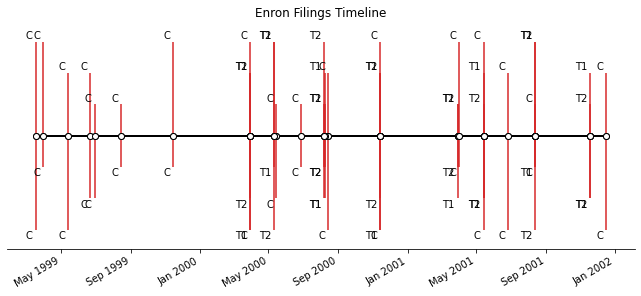

In [8]:
#Plot SEC filings on graph, Note C is for Enron Corp, T1 is for Enron Capital Trust I, T2 is Enron Capital Trust II
levels = np.tile([3, -3, 2, -2, 1, -1],
                 int(np.ceil(len(names))))[:len(names)]
ig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Enron Filings Timeline")
ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

#annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*1), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")
    
# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)

plt.show()

In [9]:
df_enron.groupby('Filing').count()

,CIX,Name,Submission Date,Txt_URL,HTML_URL
Filing,,,,,
10-K,14,14,14,14,14
10-Q,40,40,40,40,40
10-Q/A,4,4,4,4,4
11-K,8,8,8,8,8
8-K,4,4,4,4,4


In [11]:
#Import Prices
cwd = os.getcwd()
file1 = os.path.join(cwd, "../prices/enronstockchart_conv.pdf")
file2 = os.path.join(cwd, "../prices/enronstockchart-2_conv.pdf")

df1 = tabula.read_pdf(file1, pages='all', multiple_tables=True)
df2 = tabula.read_pdf(file2, pages='all', multiple_tables=True)

In [12]:
tmp = pd.DataFrame(df1[0])[2:]
df = pd.DataFrame()
df[0] = tmp[0].apply(lambda x: x.split()[0])
df[1] = tmp[0].apply(lambda x: x.split()[1])
df[2] = tmp[1].apply(lambda x: x.split()[0])
df[3] = tmp[1].apply(lambda x: x.split()[1])
df[4] = tmp[1].apply(lambda x: x.split()[2])
df[5] = tmp[1].apply(lambda x: x.split()[3])
df[6] = tmp[2]
df[7] = tmp[3]

In [13]:
#Add other pages to df
for x in range(1, len(df1)):
    tmp = pd.DataFrame(df1[x])
    df = df.append(tmp)
for x in range(len(df2)):
    tmp = pd.DataFrame(df2[x])
    df = df.append(tmp)

In [14]:
df.rename(columns={0:"Date",1:"Open",2:"High",3:"Low",4:"Close",5:"Volume",6:"Change",7:"Change %"}, inplace=True)
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
df['Close'] = df['Close'].apply(lambda x: x.replace(',', '.'))
df['Close'] = df['Close'].astype(float)

df = df.sort_values('Date', ascending=True)
df.reset_index(inplace=True, drop=True)

In [15]:
#Events Dataframe
df_events = pd.DataFrame(dates)
df_events.rename(columns={'Submission Date':'Date'}, inplace=True)
df_events['Event_Type'] = names

#Merged Prices and Events
df = df.merge(df_events, on='Date', how='left')

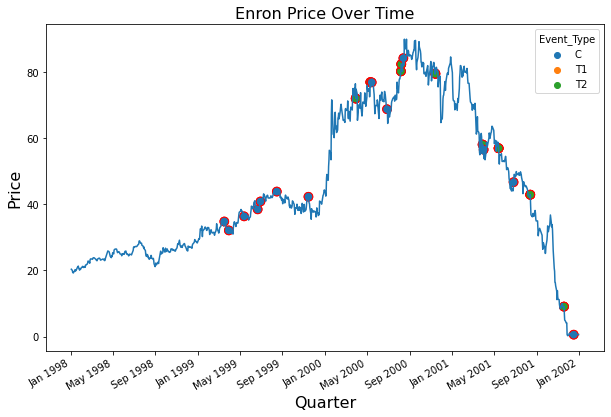

In [16]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Enron Price Over Time', fontsize=16)
ax1.set_xlabel('Quarter', fontsize=16)
ax1.set_ylabel('Price', fontsize=16)
sns.lineplot(data=df, x="Date", y="Close")
sns.scatterplot(data=df, x="Date", y="Close", hue='Event_Type', s=75, edgecolor='r',
                linewidth=1)  # Baseline and markers on it.
ax1.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")
ax1.tick_params(axis='y')
plt.show()

In [19]:
#Pickle Dataframe
cwd = os.getcwd()
filepath_pickle = os.path.join(cwd, "../dataframes/prices_events.pickle")
df.to_pickle(filepath_pickle)